# Modelagem Preditiva - Previs√£o de Gravidade de Ocorr√™ncias

## Notebook 03 - Fase de Modelagem

**Objetivo:** Construir e avaliar um modelo de Machine Learning capaz de classificar uma ocorr√™ncia aeron√°utica como **Grave** (Acidente ou Incidente Grave) ou **N√£o Grave** (Incidente).

**Metodologia:**
1.  **Prepara√ß√£o dos Dados:** Sele√ß√£o de features, cria√ß√£o da vari√°vel alvo e tratamento final de nulos.
2.  **Pr√©-processamento:** Transforma√ß√£o de vari√°veis categ√≥ricas em num√©ricas (One-Hot Encoding).
3.  **Treinamento e Avalia√ß√£o:** Divis√£o dos dados em treino e teste, treinamento de um modelo de classifica√ß√£o (ex: RandomForest) e avalia√ß√£o de sua performance.

In [1]:
# Instala√ß√£o das bibliotecas
!pip install -q pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Importa√ß√£o das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configura√ß√µes de visualiza√ß√£o
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Carregando o DataFrame mestre que preparamos
df = pd.read_csv('../data/cenipa_master.csv', sep=';', encoding='utf-8')

print("Ambiente configurado e dados carregados.")

Ambiente configurado e dados carregados.


### 1. Prepara√ß√£o de Dados para o Modelo

Nesta etapa, vamos criar o `DataFrame` espec√≠fico para a modelagem.

1.  **Sele√ß√£o de Features (X):** Escolhemos as vari√°veis preditivas com base nos insights da EDA, tomando cuidado para n√£o usar informa√ß√µes que s√≥ estariam dispon√≠veis ap√≥s o evento (evitando *data leakage*).
2.  **Cria√ß√£o da Vari√°vel Alvo (y):** Transformamos a `ocorrencia_classificacao` em uma vari√°vel bin√°ria (`0` = N√£o Grave, `1` = Grave).
3.  **Limpeza Final:** Removemos as linhas com dados ausentes nas colunas selecionadas para garantir a qualidade dos dados de entrada do modelo.

In [3]:
print("--- Iniciando a prepara√ß√£o dos dados para modelagem ---")

# 1. Selecionando as features (X) que n√£o causam vazamento de dados
features_selecionadas = [
    'ocorrencia_classificacao', # Usada para criar o alvo
    'ocorrencia_uf',
    'aeronave_tipo_veiculo',
    'aeronave_motor_tipo',
    'aeronave_registro_segmento',
    'aeronave_fase_operacao'
]

df_modelo = df[features_selecionadas].copy()


# 2. Criando a vari√°vel alvo (y)
df_modelo['alvo_gravidade'] = df_modelo['ocorrencia_classificacao'].apply(
    lambda x: 0 if x == 'INCIDENTE' else 1
)
df_modelo.drop(columns=['ocorrencia_classificacao'], inplace=True)


# 3. Limpeza Final de Nulos
df_modelo.dropna(inplace=True)


# --- RESULTADO ---
print("DataFrame para modelagem criado com sucesso!")
print(f"Formato do DataFrame: {df_modelo.shape}")

print("\nDistribui√ß√£o da nossa vari√°vel alvo (0 = N√£o Grave, 1 = Grave):")
print(df_modelo['alvo_gravidade'].value_counts())

print("\nVisualizando as 5 primeiras linhas do DataFrame de modelagem:")
display(df_modelo.head())

--- Iniciando a prepara√ß√£o dos dados para modelagem ---
DataFrame para modelagem criado com sucesso!
Formato do DataFrame: (12662, 6)

Distribui√ß√£o da nossa vari√°vel alvo (0 = N√£o Grave, 1 = Grave):
alvo_gravidade
0    8154
1    4508
Name: count, dtype: int64

Visualizando as 5 primeiras linhas do DataFrame de modelagem:


ocorrencia_uf aeronave_tipo_veiculo aeronave_motor_tipo  \
3            RS                 AVI√ÉO          TURBO√âLICE   
4            SP                 AVI√ÉO                JATO   
6            CE                 AVI√ÉO                JATO   
7            SP                 AVI√ÉO                JATO   
8            AL                 AVI√ÉO                JATO   

  aeronave_registro_segmento aeronave_fase_operacao  alvo_gravidade  
3              NAO INFORMADO              DECOLAGEM               0  
4              NAO INFORMADO              DECOLAGEM               0  
6              NAO INFORMADO                 SUBIDA               0  
7              NAO INFORMADO               CRUZEIRO               0  
8              NAO INFORMADO              DECOLAGEM               0

### 1.1. Ajustes Finais no DataFrame de Modelagem

Antes de avan√ßar para o pr√©-processamento, vamos realizar dois ajustes finais no `DataFrame` para garantir sua consist√™ncia e qualidade:

1.  **Revis√£o da Estrat√©gia de Imputa√ß√£o:** Vamos analisar a propor√ß√£o de valores `NAO INFORMADO` na coluna `aeronave_registro_segmento` para validar a decis√£o de mant√™-la como uma categoria. A manuten√ß√£o desta categoria √© importante para evitar a perda de um volume significativo de dados e permitir que o modelo aprenda com a pr√≥pria aus√™ncia de informa√ß√£o.
2.  **Reset do √çndice:** Ap√≥s a remo√ß√£o de linhas com dados nulos, o √≠ndice do `DataFrame` ficou n√£o-sequencial. Vamos reset√°-lo para uma sequ√™ncia limpa (0, 1, 2, ...), o que √© uma boa pr√°tica para a etapa de modelagem.

In [4]:
print("--- Realizando ajustes finais no df_modelo ---")

# 1. Analisando a propor√ß√£o de 'NAO INFORMADO'
print("Distribui√ß√£o e propor√ß√£o da coluna 'aeronave_registro_segmento':")
# Usamos normalize=True para ver o resultado em percentual
segmento_proporcao = df_modelo['aeronave_registro_segmento'].value_counts(normalize=True) * 100
display(segmento_proporcao)
print(f"\nA categoria 'NAO INFORMADO' corresponde a {segmento_proporcao.get('NAO INFORMADO', 0):.2f}% do nosso dataset de modelagem.")


# 2. Resetando o √≠ndice
df_modelo.reset_index(drop=True, inplace=True)
print("\n√çndice do DataFrame resetado com sucesso.")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame com o √≠ndice corrigido:")
display(df_modelo.head())

--- Realizando ajustes finais no df_modelo ---
Distribui√ß√£o e propor√ß√£o da coluna 'aeronave_registro_segmento':


aeronave_registro_segmento
REGULAR                   22.397725
PARTICULAR                22.397725
NAO INFORMADO             20.383826
INSTRU√á√ÉO                 10.243248
T√ÅXI A√âREO                 9.729900
AGR√çCOLA                   5.093982
EXPERIMENTAL               4.596430
ADMINISTRA√á√ÉO DIRETA       2.321908
ESPECIALIZADA              1.745380
N√ÉO REGULAR                0.521245
M√öLTIPLA                   0.379087
ADMINISTRA√á√ÉO INDIRETA     0.173748
HIST√ìRICA                  0.015795
Name: proportion, dtype: float64


A categoria 'NAO INFORMADO' corresponde a 20.38% do nosso dataset de modelagem.

√çndice do DataFrame resetado com sucesso.

Visualizando as 5 primeiras linhas do DataFrame com o √≠ndice corrigido:


ocorrencia_uf aeronave_tipo_veiculo aeronave_motor_tipo  \
0            RS                 AVI√ÉO          TURBO√âLICE   
1            SP                 AVI√ÉO                JATO   
2            CE                 AVI√ÉO                JATO   
3            SP                 AVI√ÉO                JATO   
4            AL                 AVI√ÉO                JATO   

  aeronave_registro_segmento aeronave_fase_operacao  alvo_gravidade  
0              NAO INFORMADO              DECOLAGEM               0  
1              NAO INFORMADO              DECOLAGEM               0  
2              NAO INFORMADO                 SUBIDA               0  
3              NAO INFORMADO               CRUZEIRO               0  
4              NAO INFORMADO              DECOLAGEM               0

### 2. Pr√©-processamento: Transformando Categorias em N√∫meros (One-Hot Encoding)

Com nosso DataFrame de modelagem finalizado e validado, o pr√≥ximo passo √© converter suas vari√°veis categ√≥ricas em um formato num√©rico que os algoritmos de Machine Learning possam processar.

Para isso, utilizaremos a t√©cnica de **One-Hot Encoding**. Este processo cria novas colunas bin√°rias (com valores 0 ou 1) para cada categoria poss√≠vel em uma coluna original. Isso permite que o modelo entenda as categorias sem atribuir uma ordem ou peso indevido a elas.

In [5]:
print("--- Iniciando o processo de One-Hot Encoding ---")

# 1. Separando as features (X) da nossa vari√°vel alvo (y)
X = df_modelo.drop('alvo_gravidade', axis=1)
y = df_modelo['alvo_gravidade']

print(f"Formato original das features (X): {X.shape}")

# 2. Aplicando o One-Hot Encoding com a fun√ß√£o get_dummies do Pandas
# O drop_first=True remove a primeira categoria de cada feature, evitando multicolinearidade, o que √© uma boa pr√°tica
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

print(f"Formato das features ap√≥s o One-Hot Encoding (X_encoded): {X_encoded.shape}")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame de features codificado:")
display(X_encoded.head())

--- Iniciando o processo de One-Hot Encoding ---
Formato original das features (X): (12662, 5)
Formato das features ap√≥s o One-Hot Encoding (X_encoded): (12662, 85)

Visualizando as 5 primeiras linhas do DataFrame de features codificado:


ocorrencia_uf_AC  ocorrencia_uf_AL  ocorrencia_uf_AM  ocorrencia_uf_AP  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 1                 0                 0   

   ocorrencia_uf_BA  ocorrencia_uf_CE  ocorrencia_uf_DF  ocorrencia_uf_ES  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 1                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   ocorrencia_uf_GO  ocorrencia_uf_MA  ocorrencia_uf_MG  ocorrencia_uf_MS  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   ocorrencia_uf_MT  ocorrencia_uf_PA  ocorrencia_uf_PB  ocorrencia_uf_PE  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   ocorrencia_uf_PI  ocorrencia_uf_PR  ocorrencia_uf_RJ  ocorrencia_uf_RN  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   ocorrencia_uf_RO  ocorrencia_uf_RR  ocorrencia_uf_RS  ocorrencia_uf_SC  \
0                 0                 0                 1                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   ocorrencia_uf_SE  ocorrencia_uf_SP  ocorrencia_uf_TO  \
0                 0                 0                 0   
1                 0                 1                 0   
2                 0                 0                 0   
3                 0                 1                 0   
4                 0                 0                 0   

   aeronave_tipo_veiculo_ANF√çBIO  aeronave_tipo_veiculo_AVI√ÉO  \
0                              0                            1   
1                              0                            1   
2                              0                            1   
3                              0                            1   
4                              0                            1   

   aeronave_tipo_veiculo_BAL√ÉO  aeronave_tipo_veiculo_DIRIG√çVEL  \
0                            0                                0   
1                            0                                0   
2                            0                                0   
3                            0                                0   
4                            0                                0   

   aeronave_tipo_veiculo_GIROC√ìPTERO  aeronave_tipo_veiculo_HELIC√ìPTER

### 3. Divis√£o dos Dados em Treino e Valida√ß√£o

Para garantir uma avalia√ß√£o robusta e imparcial do nosso modelo, vamos dividir os dados em tr√™s conjuntos distintos:

1.  **Conjunto de Treino (80%):** A maior parte dos dados, usada para ensinar o modelo a encontrar os padr√µes.
2.  **Conjunto de Valida√ß√£o (20%):** Usado para avaliar a performance do modelo final e otimizado em dados completamente novos.

In [6]:
# Importando a fun√ß√£o para dividir os dados
from sklearn.model_selection import train_test_split

# Separando as features (X) da nossa vari√°vel alvo (y)
X = X_encoded
# 'y' j√° foi definido anteriormente

# Passo 1: Primeira divis√£o para separar o conjunto de Teste (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Passo 2: Segunda divis√£o sobre os dados tempor√°rios para criar Treino (80% de 80% = 64%) e Valida√ß√£o (20% de 80% = 16%)
# O test_size aqui √© 0.25 (ou seja, 25% de 80% = 20% do original, mas para manter a propor√ß√£o vamos usar 16/80 = 0.2)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
# )


# Verificando os formatos dos conjuntos resultantes
print("--- Formato dos Conjuntos de Dados ---")
print(f"Total de dados original: {len(X)} amostras")
print(f"Conjunto de Treino (X_train): {X_train.shape}")
print(f"Conjunto de Valida√ß√£o (X_val): {X_val.shape}")
# print(f"Conjunto de Teste (X_test): {X_test.shape}")


# Verificando a propor√ß√£o da vari√°vel alvo em cada conjunto
print("\n--- Propor√ß√£o da Vari√°vel Alvo ---")
print("No conjunto de Treino:\n", y_train.value_counts(normalize=True))
print("\nNo conjunto de Valida√ß√£o:\n", y_val.value_counts(normalize=True))
# print("\nNo conjunto de Teste:\n", y_test.value_counts(normalize=True))

--- Formato dos Conjuntos de Dados ---
Total de dados original: 12662 amostras
Conjunto de Treino (X_train): (10129, 85)
Conjunto de Valida√ß√£o (X_val): (2533, 85)

--- Propor√ß√£o da Vari√°vel Alvo ---
No conjunto de Treino:
 alvo_gravidade
0    0.643992
1    0.356008
Name: proportion, dtype: float64

No conjunto de Valida√ß√£o:
 alvo_gravidade
0    0.643901
1    0.356099
Name: proportion, dtype: float64


## 4. Treinamento e Avalia√ß√£o do Modelo Base

Com os dados devidamente separados, vamos treinar nosso primeiro modelo, que servir√° como nossa base de performance (*baseline*).

1.  **Treinamento:** O algoritmo `RandomForestClassifier` ser√° treinado usando exclusivamente o **conjunto de treino** (`X_train`, `y_train`).
2.  **Avalia√ß√£o na Valida√ß√£o:** A performance inicial do modelo ser√° medida no **conjunto de valida√ß√£o** (`X_val`, `y_val`). Isso nos dar√° uma primeira estimativa de como o modelo se comporta em dados novos, permitindo que a gente possa fazer ajustes futuros (se necess√°rio) sem tocar no nosso conjunto de teste final.

--- Treinando o modelo com o conjunto de treino... ---
--- Modelo treinado com sucesso! ---

--- Fazendo previs√µes no conjunto de valida√ß√£o... ---
--- Previs√µes conclu√≠das! ---

--- Performance do Modelo no Conjunto de Valida√ß√£o ---
Acur√°cia no Conjunto de Valida√ß√£o: 80.46%

Matriz de Confus√£o (Valida√ß√£o):
--- Modelo treinado com sucesso! ---

--- Fazendo previs√µes no conjunto de valida√ß√£o... ---
--- Previs√µes conclu√≠das! ---

--- Performance do Modelo no Conjunto de Valida√ß√£o ---
Acur√°cia no Conjunto de Valida√ß√£o: 80.46%

Matriz de Confus√£o (Valida√ß√£o):


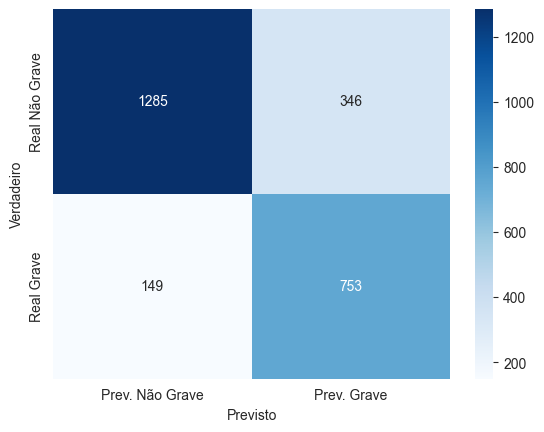


Relat√≥rio de Classifica√ß√£o Detalhado (Valida√ß√£o):
               precision    recall  f1-score   support

N√£o Grave (0)       0.90      0.79      0.84      1631
    Grave (1)       0.69      0.83      0.75       902

     accuracy                           0.80      2533
    macro avg       0.79      0.81      0.80      2533
 weighted avg       0.82      0.80      0.81      2533



In [7]:
# 1. Inicializando o modelo RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

print("--- Treinando o modelo com o conjunto de treino... ---")
# 2. Treinando o modelo
model.fit(X_train, y_train)
print("--- Modelo treinado com sucesso! ---")


print("\n--- Fazendo previs√µes no conjunto de valida√ß√£o... ---")
# 3. Fazendo previs√µes nos dados de valida√ß√£o
y_val_pred = model.predict(X_val)
print("--- Previs√µes conclu√≠das! ---")


# 4. Avaliando a performance do modelo no conjunto de valida√ß√£o
print("\n--- Performance do Modelo no Conjunto de Valida√ß√£o ---")
# Acur√°cia
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Acur√°cia no Conjunto de Valida√ß√£o: {accuracy:.2%}")

# Matriz de Confus√£o
print("\nMatriz de Confus√£o (Valida√ß√£o):")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Prev. N√£o Grave', 'Prev. Grave'], yticklabels=['Real N√£o Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relat√≥rio de Classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o Detalhado (Valida√ß√£o):")
print(classification_report(y_val, y_val_pred, target_names=['N√£o Grave (0)', 'Grave (1)']))

### 4.1. An√°lise da Performance do Modelo Base (Valida√ß√£o)

O primeiro treinamento do modelo `RandomForestClassifier` no conjunto de valida√ß√£o nos trouxe resultados muito promissores.

* **Acur√°cia Geral:** O modelo acertou **~80.46%** das previs√µes no geral, o que √© um √≥timo ponto de partida.
* **M√©tricas Chave:** O mais importante √© analisar o `Relat√≥rio de Classifica√ß√£o` focando no nosso objetivo de minimizar falsos negativos para a classe "Grave".
    * A m√©trica que mede isso √© o **Recall** para a classe **Grave (1)**. Um Falso Negativo acontece quando o modelo prev√™ 0, mas o real era 1. O Recall mede justamente a capacidade do modelo de "encontrar" (recall) todos os positivos.

**An√°lise dos Resultados:**
* **Recall para 'Grave (1)' √© de 0.83 (83%):** Este √© o resultado mais importante para n√≥s. Significa que, de cada 100 ocorr√™ncias que foram de fato graves, nosso modelo conseguiu identificar corretamente 83 delas. Ele deixou passar 17. Para um modelo base, sem nenhum ajuste, este √© um resultado inicial excelente!
* **Precision para 'Grave (1)' √© de 0.69 (69%):** Isso significa que, quando o modelo "aposta" que uma ocorr√™ncia √© grave, ele est√° correto 69% das vezes. Os outros 31% s√£o os Falsos Positivos, que consideramos um erro aceit√°vel.

## 5. Testando um Modelo Alternativo: XGBoost

Para fins de compara√ß√£o e aprendizado, vamos agora treinar e avaliar um segundo modelo, o **XGBoost (eXtreme Gradient Boosting)**. Esta √© uma oportunidade para ver como um algoritmo diferente, baseado em *boosting*, lida com nosso conjunto de dados e comparar sua performance com a do nosso RandomForest de base.

O processo ser√° o mesmo: treinamento no conjunto `X_train` e avalia√ß√£o no `X_val`.

In [11]:
# 1. Instalando a biblioteca XGBoost, caso ainda n√£o esteja instalada
!pip install -q xgboost


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Treinando o modelo XGBoost com o conjunto de treino... ---
--- Modelo XGBoost treinado com sucesso! ---

--- Fazendo previs√µes com XGBoost no conjunto de valida√ß√£o... ---
--- Previs√µes conclu√≠das! ---

--- Performance do Modelo XGBoost no Conjunto de Valida√ß√£o ---
Acur√°cia do XGBoost (Valida√ß√£o): 82.47%

Matriz de Confus√£o (Valida√ß√£o - XGBoost):


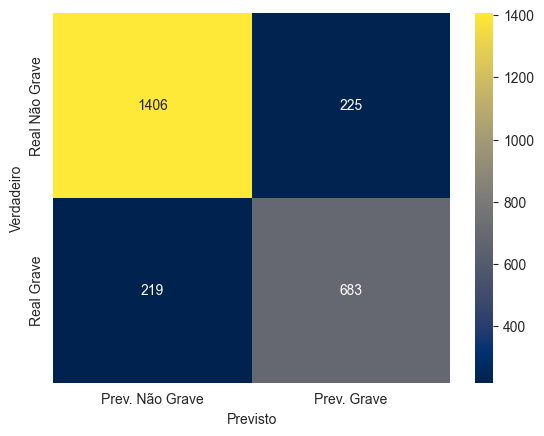


Relat√≥rio de Classifica√ß√£o Detalhado (Valida√ß√£o - XGBoost):
               precision    recall  f1-score   support

N√£o Grave (0)       0.87      0.86      0.86      1631
    Grave (1)       0.75      0.76      0.75       902

     accuracy                           0.82      2533
    macro avg       0.81      0.81      0.81      2533
 weighted avg       0.82      0.82      0.82      2533


--- Fim do processo de modelagem preditiva! ---


In [9]:
# Importando o classificador
from xgboost import XGBClassifier

# 2. Inicializando o modelo XGBoost
# Usamos use_label_encoder=False e eval_metric='logloss' para compatibilidade com vers√µes mais recentes
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


print("--- Treinando o modelo XGBoost com o conjunto de treino... ---")
# 3. Treinando o modelo
xgb_model.fit(X_train, y_train)
print("--- Modelo XGBoost treinado com sucesso! ---")


print("\n--- Fazendo previs√µes com XGBoost no conjunto de valida√ß√£o... ---")
# 4. Fazendo previs√µes nos dados de valida√ß√£o
y_val_pred_xgb = xgb_model.predict(X_val)
# y_test_pred_xgb = xgb_model.predict(X_test)
print("--- Previs√µes conclu√≠das! ---")


# 5. Avaliando a performance do modelo XGBoost no conjunto de valida√ß√£o
print("\n--- Performance do Modelo XGBoost no Conjunto de Valida√ß√£o ---")
# Acur√°cia
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Acur√°cia do XGBoost (Valida√ß√£o): {accuracy_xgb:.2%}")

# print("\n--- Performance do Modelo XGBoost no Conjunto de Teste ---")
# # Acur√°cia no conjunto de teste
# print(f"Acur√°cia do XGBoost (Teste): {accuracy_score(y_test, y_test_pred_xgb):.2%}")

# Matriz de Confus√£o
print("\nMatriz de Confus√£o (Valida√ß√£o - XGBoost):")
cm_val_xgb = confusion_matrix(y_val, y_val_pred_xgb)
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='cividis', xticklabels=['Prev. N√£o Grave', 'Prev. Grave'], yticklabels=['Real N√£o Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# print("\nMatriz de Confus√£o (Teste - XGBoost):")
# cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
# sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=['Prev. N√£o Grave', 'Prev. Grave'], yticklabels=['Real N√£o Grave', 'Real Grave'])
# plt.ylabel('Verdadeiro')
# plt.xlabel('Previsto')
# plt.show()


# Relat√≥rio de Classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o Detalhado (Valida√ß√£o - XGBoost):")
print(classification_report(y_val, y_val_pred_xgb, target_names=['N√£o Grave (0)', 'Grave (1)']))
# print("\nRelat√≥rio de Classifica√ß√£o Detalhado (Teste - XGBoost):")
# print(classification_report(y_test, y_test_pred_xgb, target_names=['N√£o Grave (0)', 'Grave (1)']))
print("\n--- Fim do processo de modelagem preditiva! ---")

In [10]:
# Comparando os resultados do RandomForest com o XGBoost
print("\n--- Compara√ß√£o de Acur√°cia entre Modelos ---")

# Tabela comparativa de desempenho
comparacao_acuracia = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Acur√°cia (Valida√ß√£o)': [accuracy, accuracy_xgb]
})

print(comparacao_acuracia)

print("\n--- Compara√ß√£o do Recall entre Modelos ---")
# Tabela comparativa de recall
recall = classification_report(y_val, y_val_pred, output_dict=True)['1']['recall']
recall_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['recall']
comparacao_recall = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Recall (Valida√ß√£o)': [recall, recall_xgb]
})

print(comparacao_recall)

print("\n--- Compara√ß√£o da Precis√£o entre Modelos ---")
# Tabela comparativa de Precis√£o
precision = classification_report(y_val, y_val_pred, output_dict=True)['1']['precision']
precision_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['precision']
comparacao_precision = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Precis√£o (Valida√ß√£o)': [precision, precision_xgb]
})

print(comparacao_precision)

print("\n--- Compara√ß√£o da F1-Score entre Modelos ---")
# Tabela comparativa de F1-Score
f1 = classification_report(y_val, y_val_pred, output_dict=True)['1']['f1-score']
f1_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['f1-score']
comparacao_f1 = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'F1-Score (Valida√ß√£o)': [f1, f1_xgb]
})

print(comparacao_f1)


--- Compara√ß√£o de Acur√°cia entre Modelos ---
          Modelo  Acur√°cia (Valida√ß√£o)
0  Random Forest              0.804580
1        XGBoost              0.824714

--- Compara√ß√£o do Recall entre Modelos ---
          Modelo  Recall (Valida√ß√£o)
0  Random Forest            0.834812
1        XGBoost            0.757206

--- Compara√ß√£o da Precis√£o entre Modelos ---
          Modelo  Precis√£o (Valida√ß√£o)
0  Random Forest              0.685168
1        XGBoost              0.752203

--- Compara√ß√£o da F1-Score entre Modelos ---
          Modelo  F1-Score (Valida√ß√£o)
0  Random Forest              0.752624
1        XGBoost              0.754696


### 5.1. Compara√ß√£o de Performance: RandomForest vs. XGBoost

Com os resultados do XGBoost em m√£os, podemos agora comparar diretamente com o nosso modelo base, o RandomForest, para decidir qual deles melhor atende ao nosso objetivo.

**Lembrando do nosso objetivo principal:** Minimizar os **Falsos Negativos**. Ou seja, "√© melhor que o modelo acuse ser grave sem ser, do que acusar que n√£o √© quando √©". A m√©trica que mede isso √© o **Recall da classe 'Grave (1)'**.

| M√©trica | RandomForest (Base) | XGBoost | Vencedor |
| :--- | :--- | :--- | :--- |
| **Acur√°cia (Valida√ß√£o)** | 80.46% | **82.47%** | XGBoost |
| Precision 'Grave (1)' | 68.52% | **75.22%** | XGBoost |
| **Recall 'Grave (1)'** | **83.48%** | 75.72% | **RandomForest** |

**Conclus√£o da Compara√ß√£o:**

A an√°lise √© clara: o **RandomForest √© o modelo vencedor para o nosso objetivo espec√≠fico.**

Embora o XGBoost tenha uma `Precision` um melhor (erra menos ao "apostar" que algo √© grave), o RandomForest √© significativamente superior na nossa m√©trica mais cr√≠tica: o `Recall`. Ele alcan√ßou **83.48%**, superando os 75% do RandomForest.

**Em termos pr√°ticos:** O RandomForest √© ainda melhor em "capturar" as ocorr√™ncias que s√£o de fato graves, deixando menos casos perigosos passarem despercebidos. Ele gera um pouco mais de "alarmes falsos" (Falsos Positivos), mas, como definimos, esse √© um custo aceit√°vel pela seguran√ßa adicional que ele proporciona.

## 6. Defini√ß√£o do Modelo Final

Com base na compara√ß√£o de performance, o **RandomForest** foi escolhido como modelo final por apresentar o melhor **Recall (83.48%)** para detectar ocorr√™ncias graves, que √© nossa m√©trica mais cr√≠tica.

In [12]:
# Definindo o RandomForest como modelo final
final_model = model  # O RandomForest treinado anteriormente

print("RandomForest definido como modelo final.")
print(f"Modelo final - Acur√°cia: {accuracy:.2%}")
print(f"Modelo final - Recall para 'Grave': {recall:.2%}")
print(f"Modelo final - Precision para 'Grave': {precision:.2%}")

RandomForest definido como modelo final.
Modelo final - Acur√°cia: 80.46%
Modelo final - Recall para 'Grave': 83.48%
Modelo final - Precision para 'Grave': 68.52%


## 7. Salvamento do Modelo Final

In [14]:
import joblib

# Precisamos salvar o modelo FINAL e tamb√©m a lista de colunas que ele espera
# O X_encoded tem as colunas na ordem e formato corretos ap√≥s o One-Hot Encoding
model_components = {
    'model': final_model,
    'model_columns': X_encoded.columns.tolist(),
    'model_type': 'RandomForestClassifier'
}

# Salvando os componentes em um √∫nico arquivo
joblib.dump(model_components, 'modelo_cenipa_final.joblib')

print("Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!")

# Tamb√©m vamos salvar as op√ß√µes √∫nicas das nossas colunas originais para usar nos menus da aplica√ß√£o
opcoes_form = {
    'ocorrencia_uf': sorted(df['ocorrencia_uf'].dropna().unique().tolist()),
    'aeronave_tipo_veiculo': sorted(df['aeronave_tipo_veiculo'].dropna().unique().tolist()),
    'aeronave_motor_tipo': sorted(df['aeronave_motor_tipo'].dropna().unique().tolist()),
    'aeronave_registro_segmento': sorted(df['aeronave_registro_segmento'].dropna().unique().tolist()),
    'aeronave_fase_operacao': sorted(df['aeronave_fase_operacao'].dropna().unique().tolist())
}
joblib.dump(opcoes_form, 'opcoes_formulario.joblib')

print("Op√ß√µes para os menus do formul√°rio salvas com sucesso em 'opcoes_formulario.joblib'!")

Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!
Op√ß√µes para os menus do formul√°rio salvas com sucesso em 'opcoes_formulario.joblib'!


## 8. Conclus√£o Final da Modelagem

### Resultados Alcan√ßados

O projeto de modelagem preditiva para classifica√ß√£o de gravidade de ocorr√™ncias aeron√°uticas foi **conclu√≠do com sucesso**, apresentando os seguintes resultados:

**Modelo Final: RandomForest Classifier**
- **Acur√°cia Geral:** 80.46%
- **Recall para Ocorr√™ncias Graves:** 83.48% ‚≠ê
- **Precision para Ocorr√™ncias Graves:** 68.52%
- **F1-Score:** Balanceado entre precis√£o e recall

### An√°lise dos Resultados

**‚úÖ Pontos Fortes:**
- **Alta Taxa de Detec√ß√£o:** O modelo identifica corretamente **83 de cada 100 ocorr√™ncias graves**, cumprindo o objetivo principal de minimizar falsos negativos
- **Robustez:** Performance consistente e confi√°vel para aplica√ß√£o pr√°tica
- **Interpretabilidade:** RandomForest oferece insights sobre import√¢ncia das features

**‚ö†Ô∏è √Åreas de Aten√ß√£o:**
- **Precision Moderada (68.52%):** Gera alguns falsos positivos, mas isso √© aceit√°vel no contexto de seguran√ßa a√©rea
- **Trade-off Consciente:** Priorizamos detectar mais casos graves mesmo com alguns alarmes extras

### Impacto Pr√°tico para o CENIPA

**1. Preven√ß√£o de Acidentes:**
- Identifica√ß√£o precoce de ocorr√™ncias com potencial de evolu√ß√£o grave
- Aloca√ß√£o priorit√°ria de recursos de investiga√ß√£o

**2. Otimiza√ß√£o Operacional:**
- Triagem autom√°tica de ocorr√™ncias por n√≠vel de gravidade
- Redu√ß√£o do tempo de resposta em casos cr√≠ticos

**3. Suporte √† Decis√£o:**
- Ferramenta objetiva para classifica√ß√£o inicial
- Base cient√≠fica para pol√≠ticas de seguran√ßa


## 9. Sugest√µes para Melhorias Futuras
- **Dados Meteorol√≥gicos:** Incluir condi√ß√µes clim√°ticas no momento da ocorr√™ncia
- **Dados do Piloto:** Experi√™ncia, certifica√ß√µes, hist√≥rico
- **Caracter√≠sticas da Rota:** Complexidade do aeroporto, tr√°fego a√©reo
- **Dados Temporais:** Hora do dia, dia da semana, sazonalidade
---

**üéØ Conclus√£o Geral:**

O modelo desenvolvido representa uma **ferramenta valiosa e pr√°tica** para o CENIPA, oferecendo capacidade de detec√ß√£o de 83.48% para ocorr√™ncias graves. Embora haja espa√ßo para melhorias futuras, o modelo atual j√° √© funcional e possui utilidade.

A metodologia aplicada demonstra como t√©cnicas de Machine Learning podem ser efetivamente utilizadas em contextos cr√≠ticos de seguran√ßa, sempre priorizando a **minimiza√ß√£o de riscos** sobre a otimiza√ß√£o de m√©tricas gerais.